In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import zscore, iqr
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, f_classif

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


# Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Clustering
from sklearn.cluster import KMeans

# Other
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import shapiro
from sklearn.decomposition import PCA

# Archive
import joblib

# my ds module
# from ds import plot_boxes, plot_crosstabs, plot_histograms
from ds import plots

## Regression

### Target Variable

In [ ]:
target_regression = 'Amount_invested_monthly'
# target_regression = 'Total_EMI_per_month'

In [ ]:
df_regression = df_numeric

### Feature Selection

In [ ]:
threshold_correlation = 0.2
correlations = df_regression.corr()[target_regression]
features_regression = correlations[correlations.abs() > threshold_correlation].index.tolist()
if len(features_regression) == 0:
    print(f"Warning: No features have a correlation with '{target_regression}' above the threshold of {threshold_correlation}")

print(features_regression)


['Num_Bank_Accounts', 'Interest_Rate', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Amount_invested_monthly', 'Log_Annual_Income']


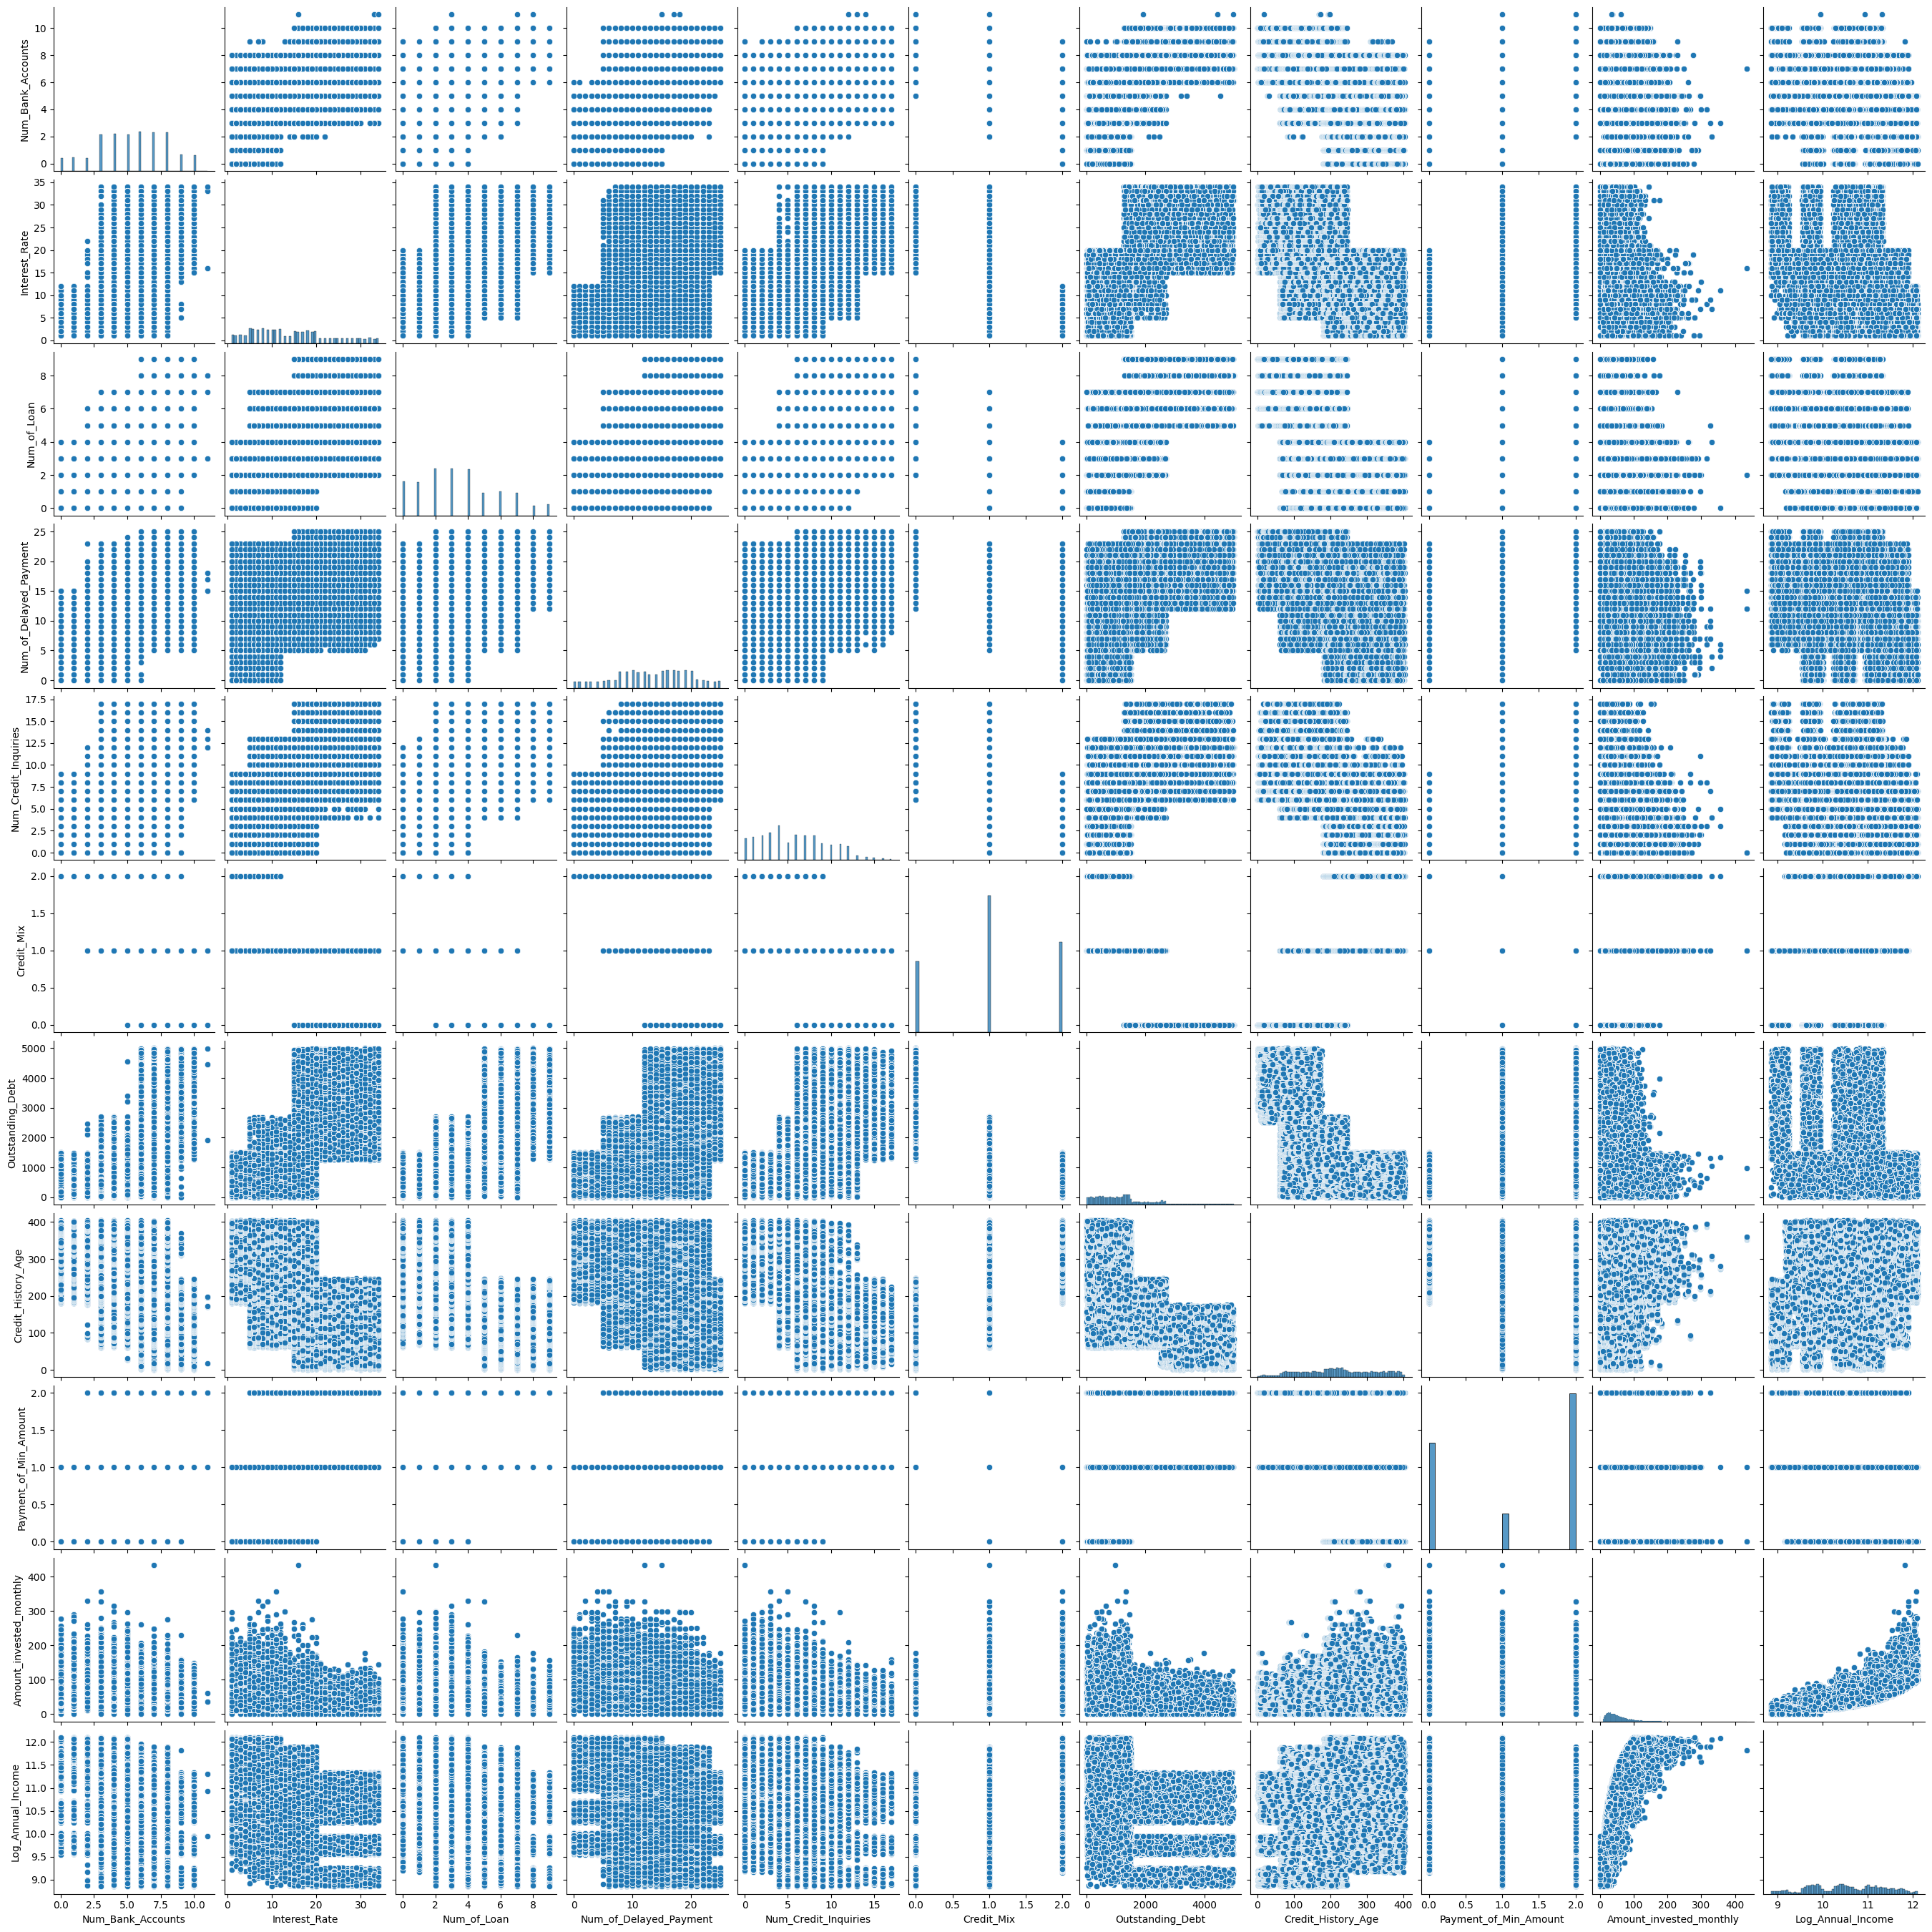

In [ ]:
if run_plots:
    # Create the pairplot
    sns.pairplot(df_regression[features_regression])
    # Show the plot
    plt.show()

In [ ]:
def get_features_regression(df, target):
    selector = SelectKBest(f_regression, k=6)

    # Fit the selector and transform the data
    selector.fit_transform(df, df[target])

    # Get the selected feature names
    if hasattr(selector, "get_support"):
        return df.columns[selector.get_support()]
    else:
        return df.columns    

In [ ]:
features_regression = get_features_regression(df_regression, target_regression)
features_regression

Index(['Interest_Rate', 'Num_of_Delayed_Payment', 'Credit_Mix',
       'Payment_of_Min_Amount', 'Amount_invested_monthly',
       'Log_Annual_Income'],
      dtype='object')

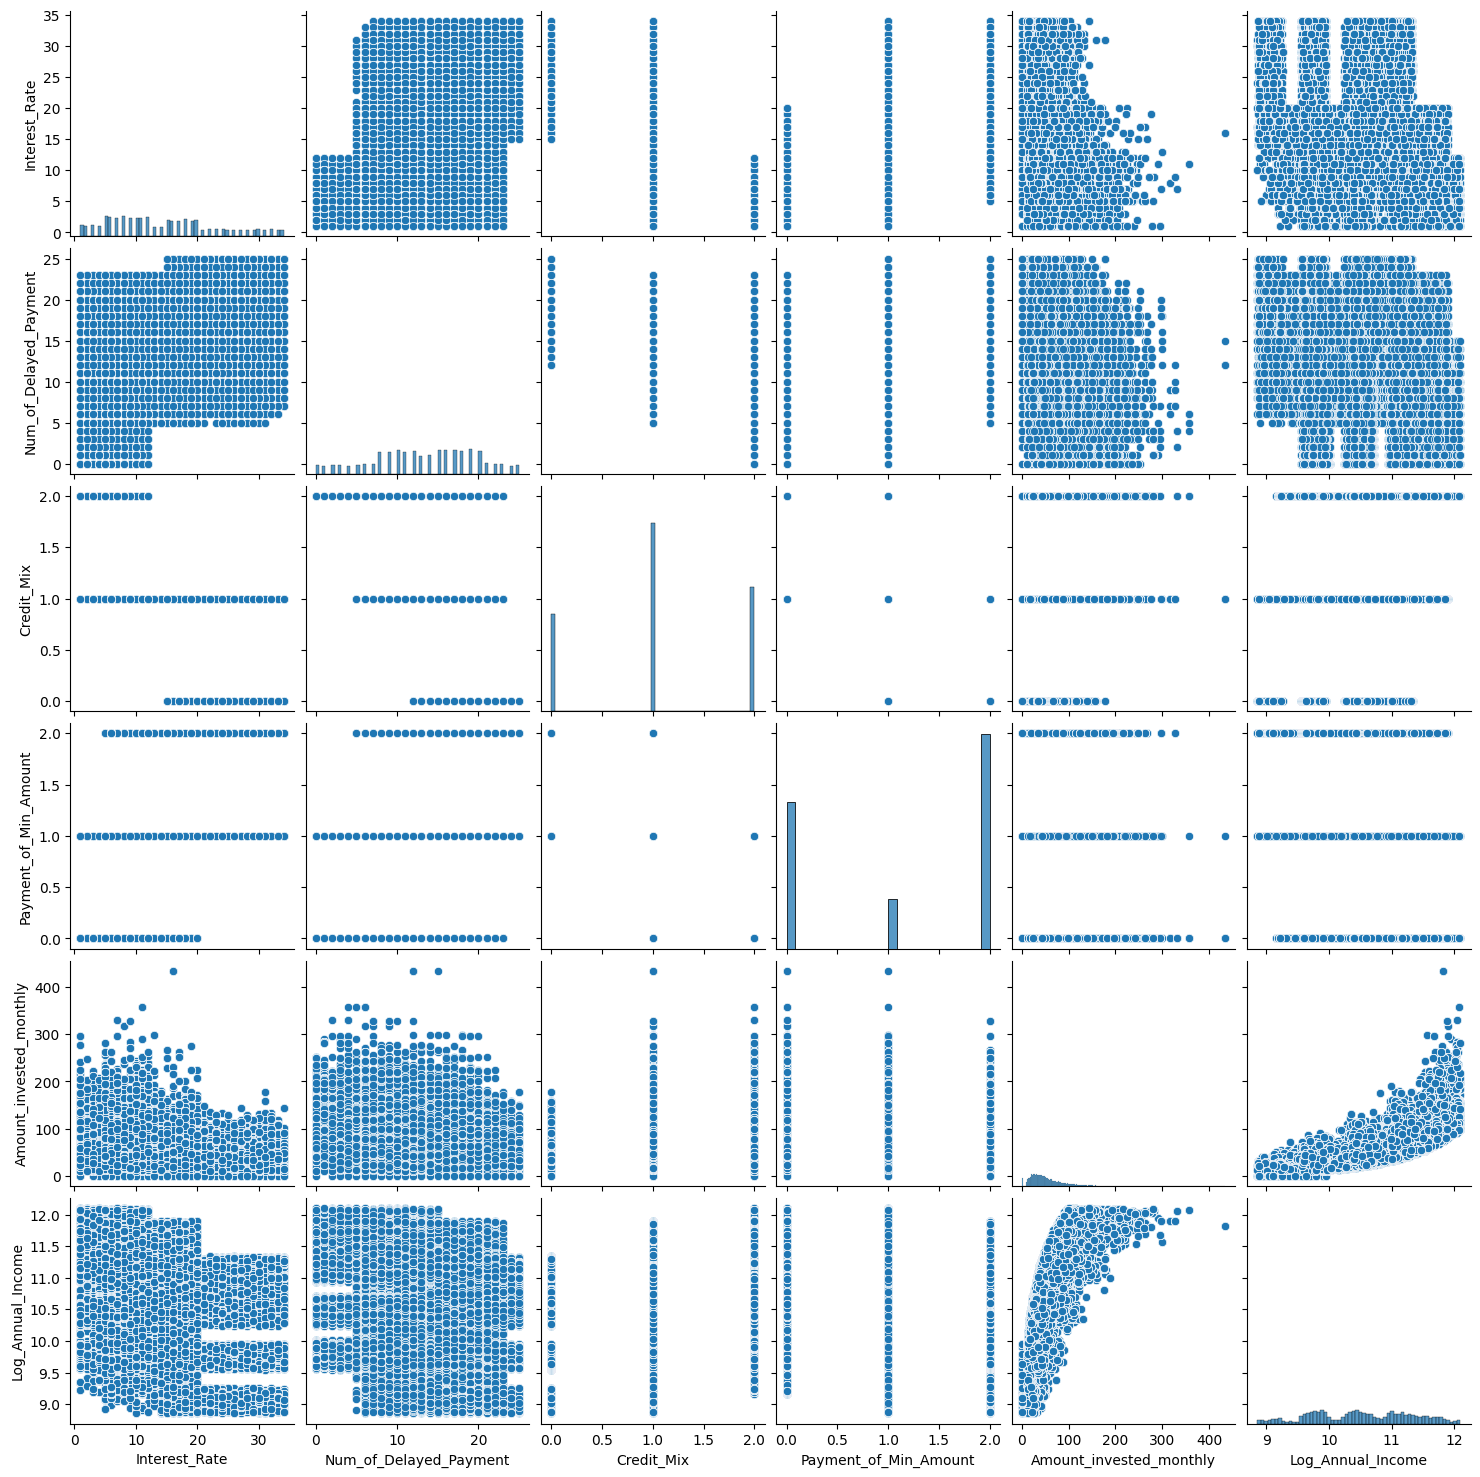

In [ ]:
if run_plots:
    # Create the pairplot
    sns.pairplot(df_regression[features_regression])
    # Show the plot
    plt.show()

### Train-Test Split

In [ ]:
# Create a new DataFrame with the selected features and the target variable
data_reg_X = df_regression[features_regression].drop(target_regression, axis=1)
data_reg_y = df_regression[target_regression]

print(data_reg_X.columns)

Index(['Interest_Rate', 'Num_of_Delayed_Payment', 'Credit_Mix',
       'Payment_of_Min_Amount', 'Log_Annual_Income'],
      dtype='object')


In [ ]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_reg_X, data_reg_y, test_size=0.33, random_state=69)

scaler = StandardScaler() # or MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Algorithm Selection

In [ ]:
# scores =[]

# # values = [10, 20, 50, 100, 200]
# values = range(10, 300, 50)
# # values = range(5, 50, 5)
# # values = range(5, 100, 10)

# for k in values:
#     rfr = RandomForestRegressor(n_estimators=k)
#     rfr.fit(X_train_scaled, y_train)
#     y_pred = rfr.predict(X_test_scaled)
#     print(k, r2_score(y_test, y_pred))
#     scores.append(r2_score(y_test, y_pred))

# # plot the relationship between K and testing accuracy
# # plt.plot(x_axis, y_axis)
# plt.plot(values, scores)
# plt.xlabel('Value of n_estimators for Random Forest Classifier')
# plt.ylabel('r2_score')

In [ ]:
# Models and Parameter Grids (you can add more models and parameters)
models = {
    'LinearRegression': (LinearRegression(), {}),
    'RandomForest': (
        RandomForestRegressor(random_state=69),
        {
             'n_estimators': [
                 10, 20, 50, 100, 
                 200
                 ],
             'max_depth': [None,
                        #    5, 10
                           ]
        }
    ),
    # 'SVR': (SVR(),
    #         {
    #             'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Different kernel functions
    #             'C': [0.1, 1, 10],       # Regularization parameter (inverse of strength)
    #             'epsilon': [0.1, 0.01]  # Tolerance for error
    #         })
}

In [ ]:
if run_regression:
    # Grid Search with Cross-Validation
    best_score = float('inf')  # Initialize with a high value
    best_model = None

    for name, (model, param_grid) in models.items():
        print(f"\nPerforming Grid Search for {name}...")
        grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_percentage_error', cv=5)
        grid_search.fit(X_train_scaled, y_train)

        print(f"Best parameters: {grid_search.best_params_}")
        # print(f"Best score: {-grid_search.best_score_:.2f}")

        # Check if the current model is better than the previous best
        if -grid_search.best_score_ < best_score:
            best_score = -grid_search.best_score_
            best_model = grid_search.best_estimator_


    print(f"\nBest Model: {best_model}")
    model_regression = best_model


Performing Grid Search for LinearRegression...
Best parameters: {}

Performing Grid Search for RandomForest...
Best parameters: {'max_depth': None, 'n_estimators': 10}

Best Model: RandomForestRegressor(n_estimators=10, random_state=69)


### Manual model selection

In [ ]:
# model_regression = LinearRegression()
# model_regression = RandomForestRegressor(n_estimators=200)

# model_regression.fit(X_train_scaled, y_train)

### Model Evaluation

In [ ]:
if run_regression:
    # Evaluate the best model on the test set
    y_pred = model_regression.predict(X_test_scaled)

    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nMetrics for {target_regression}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R-squared: {r2:.2f}")

    regression_r2 = r2


Metrics for Amount_invested_monthly:
  RMSE: 6.51
  MAE: 2.59
  R-squared: 0.97


### Save data

In [ ]:
if run_regression:
    joblib.dump(model_regression, 'model_regression.pkl')
    data_reg_X.to_csv('data_regres_X.csv', index=False)
    data_reg_y.to_csv('data_regres_y.csv', index=False)